In [1]:
import matplotlib.pyplot as plt
from src.pvsys import ShadedArray

In [2]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [
            CB91_Blue,
            CB91_Amber,
            CB91_Green,
            CB91_Violet,
            CB91_Pink,
            CB91_Purple,
            ]
              
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

In [3]:
IRRADIANCES = [
    [900, 300, 900, 900],
    [800, 200, 200, 800],
    [100, 200, 300, 600],
]
CELL_TEMPS = [
    [25, 25, 25, 25],
    [25, 25, 25, 25],
    [25, 25, 25, 25],
]
TEMPERATURES = [
    [ShadedArray.ambient_temp_from_cell(g, ct)]
    for amb in zip(IRRADIANCES, CELL_TEMPS)
    for g, ct in zip(*amb)
]

pvsyss = ShadedArray.get_default_array()

In [4]:
class LMPP:
    def __init__(self, lmpps):
        self.voltage = []
        self.current = []
        self.power = []

        for lmpp in lmpps:
            v = lmpp.voltage
            i = lmpp.current
            self.voltage.append(v)
            self.current.append(i)
            self.power.append(v * i)
    

In [5]:
POINTS_PER_CURVE = (1000,)*3
curves = []
powers = []
mpps = []
lmpps = []

for g, t, points in zip(IRRADIANCES, TEMPERATURES, POINTS_PER_CURVE):
    pvsyss.simulate(
        duty_cycle=0.0,
        irradiance=g,
        ambient_temperature=t,
    )
    curve = pvsyss.get_shaded_iv_curve(curve_points=points)
    mpp = pvsyss.mpp_from_curve(curve)

    lmpps.append(LMPP([pt for pt in ShadedArray.allmpp_from_curve(curve) if not pt == mpp]))
    powers.append(pvsyss.power(curve.voltage, curve.current))
    mpps.append(mpp)
    curves.append(curve)

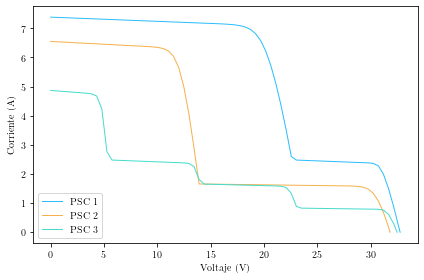

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Voltaje (V)")
ax.set_ylabel("Corriente (A)")

# plot iv curve
for i, (curve, color) in enumerate(zip(curves, color_list), start=1):
    label = f'PSC {i}'
    ax.plot(curve.voltage, curve.current, linewidth=1.0, label=label, color=color)

ax.legend(loc='lower left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig(r'output/ch2_multiple_iv_curves_shaded.pdf', bbox_inches='tight')

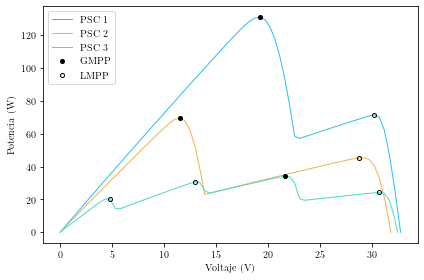

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Voltaje (V)")
ax.set_ylabel("Potencia (W)")

# plot pv curve
for i, (curve, p, mpp, lmpp, g, t, color) in enumerate(zip(curves, powers, mpps, lmpps, IRRADIANCES, CELL_TEMPS, color_list), start=1):
    label = f'PSC {i}'
    ax.plot(curve.voltage, p, linewidth=1.0, label=label, color=color)

# plot mpps and lmpps
for mpp, lmpp in zip(mpps, lmpps):
    ax.plot(mpp.voltage, mpp.current * mpp.voltage, 'o', color='k', ms=4.0)
    ax.plot(lmpp.voltage, lmpp.power, 'o', color='k', markerfacecolor='none', ms=4.0)
    
# dummy plot for legend
ax.plot([],[], 'o', color='k', ms=4.0, label='$\\textrm{GMPP}$')
ax.plot([],[], 'o', color='k', markerfacecolor='none', ms=4.0, label=f'LMPP')

ax.legend(loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig(r'output/ch2_multiple_pv_curves_shaded.pdf', bbox_inches='tight')